# Installing Needed Libraries

# Importing Needed Libraries

# Loading Data

In [98]:
import numpy as np
import pandas as pd

In [121]:
data1 = pd.read_csv( 'train.csv')

data2 = pd.read_csv( 'comments.csv')

data3 = pd.read_csv( 'comments2.csv')

data = pd.concat( ( data1, data2, data3))

import sklearn
data = sklearn.utils.shuffle( data)

X = data[ 'comment']
y = data[ 'label']

# Exploring Data

In [122]:
print( X.shape, y.shape)

(4425,) (4425,)


<Axes: xlabel='label', ylabel='count'>

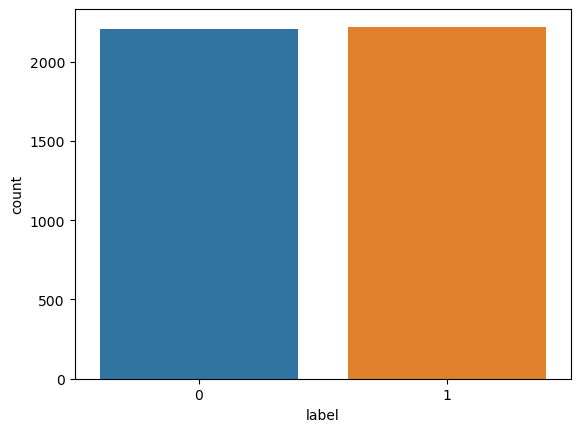

In [123]:
import seaborn as sns

sns.countplot(x=y)

# Preprocessing

In [102]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

stop = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aminb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
import string

punctuation = list(string.punctuation)
stop.update(punctuation)

In [104]:
import re

In [105]:
def split_into_words(text):
    words = text.split()
    return words

def remove_punctuation(words):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def remove_stopwords(words):
    stop_words = set(stopwords.words('arabic'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    return ' '.join(words)

def denoise_text(text):
    words = split_into_words(text)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [106]:
X.apply( denoise_text)

1166    والمسلسلات التركيه عندكوم الميزانية ديالها وال...
714                  منظر راءع جمال بلادي الله يزيد يبارك
86      خصنا نفهمو حاجة وحدة بلي رجعو جواز تلقيح ايجبا...
485     اللقاح كايحقق نتائج، وكورونا مستمر الانتشار بش...
860     وزير الصحة يقول تلقيح الساكنة المغربية كلها بن...
                              ...                        
906                   الحمد لله اغاثنا قدر بنيتنا التحتية
268     الحياة صارت معقدة، والإجراءات الوقائية كاينش ت...
1000    دولة اللصوص ملايير تنفق اجل تشجييع الفساد حساب...
1625                                    التلقيح حتا القبر
764     لازم الحرية الشخصية امور كهذه أصحاب الحساسية ع...
Name: comment, Length: 4425, dtype: object

In [107]:
#!git lfs install
#!git clone https://huggingface.co/SI2M-Lab/DarijaBERT

from transformers import AutoTokenizer, AutoModel

DarijaBERT_tokenizer = AutoTokenizer.from_pretrained("DarijaBERT")
DarijaBert_model = AutoModel.from_pretrained("DarijaBERT")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertModel were not initialized from the model checkpoint at DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [108]:
X_tokens = DarijaBERT_tokenizer( list( X), truncation=True, padding=True, return_tensors="np", max_length=128)
word_index = DarijaBERT_tokenizer.get_vocab()
VOCAB_SIZE = len(word_index) + 1
VOCAB_SIZE

80001

In [109]:
maxlen = max([len(x) for x in X])
maxlen = 128

In [110]:
DarijaBERT_tokenizer.add_tokens( list( X_tokens))

3

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify = y)

<Axes: xlabel='label', ylabel='count'>

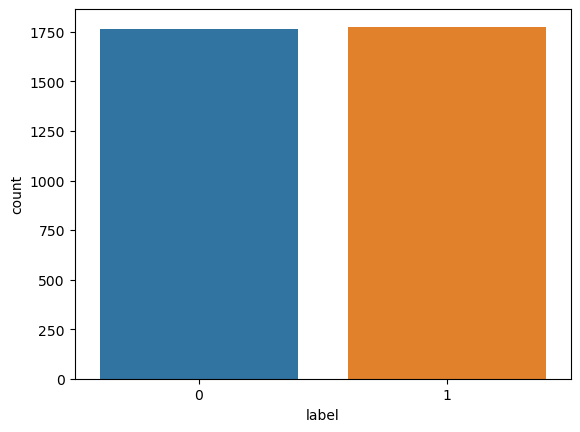

In [112]:
sns.countplot( x=y_train)

<Axes: xlabel='label', ylabel='count'>

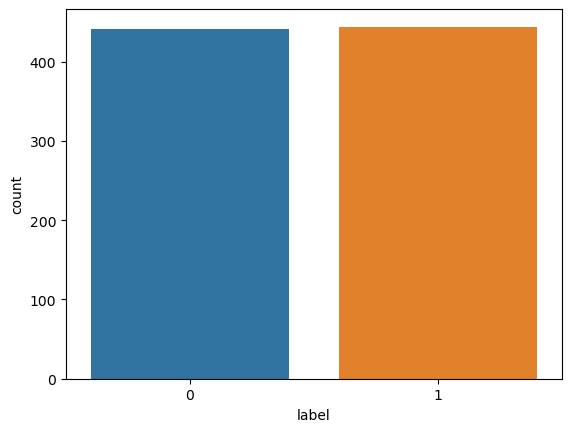

In [113]:
sns.countplot( x=y_test)

In [114]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and encode the training sequences
train_encodings = DarijaBERT_tokenizer( list( X_train), truncation=True, padding='max_length', max_length=maxlen)

# Tokenize and encode the test sequences
test_encodings = DarijaBERT_tokenizer( list( X_test), truncation=True, padding='max_length', max_length=maxlen)


# Pad the sequences if needed (optional, depending on your requirements)
train_padded_sequences = pad_sequences( train_encodings['input_ids'], maxlen=maxlen, padding='post', truncating='post')
test_padded_sequences = pad_sequences( test_encodings['input_ids'], maxlen=maxlen, padding='post', truncating='post')

In [115]:
len( train_padded_sequences[6])

128

# Data Modeling

In [116]:
embedding_dim = 64

In [117]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

EarlyStopping = EarlyStopping(monitor='val_loss', 
                                patience=3, 
                                restore_best_weights=True)


In [118]:
model_save = ModelCheckpoint('best_model_27_11.keras',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose= 1)

In [119]:
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=5,
                            verbose=0,
                            mode="max",
                            min_delta=0.0001)

In [125]:
import tensorflow as tf

embedding_matrix = DarijaBert_model.embeddings.word_embeddings.weight.detach().numpy()

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE-1, embedding_matrix.shape[1], weights=[embedding_matrix], input_length=maxlen, trainable=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense( embedding_dim, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001), metrics = ['accuracy'])

In [126]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 128, 768)          61440000  
                                                                 
 bidirectional_5 (Bidirecti  (None, 32)                100480    
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 32)                0         
                                                                 
 batch_normalization_10 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 64)               

In [127]:
from tensorflow.keras.models import load_model


history = model.fit( train_padded_sequences, y_train,
                       validation_split=0.3,
                       epochs = 50,
                       batch_size= 32,
                       callbacks=[ EarlyStopping, model_save, rlr])

Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.8741 - accuracy: 0.5210
Epoch 1: val_loss improved from inf to 0.68900, saving model to best_model_27_11.keras
78/78 [==============================] - 90s 1s/step - loss: 0.8741 - accuracy: 0.5210 - val_loss: 0.6890 - val_accuracy: 0.5198 - lr: 1.0000e-04
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.7674 - accuracy: 0.5597
Epoch 2: val_loss improved from 0.68900 to 0.68294, saving model to best_model_27_11.keras
78/78 [==============================] - 78s 1s/step - loss: 0.7674 - accuracy: 0.5597 - val_loss: 0.6829 - val_accuracy: 0.5348 - lr: 1.0000e-04
Epoch 3/50
78/78 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.6029
Epoch 3: val_loss improved from 0.68294 to 0.67262, saving model to best_model_27_11.keras
78/78 [==============================] - 79s 1s/step - loss: 0.7039 - accuracy: 0.6029 - val_loss: 0.6726 - val_accuracy: 0.5527 - lr: 1.0000e-04
Epoch 4/50


In [ ]:
print( X_test.iloc[99],'label: ;',y_test[99])

KeyError: 99

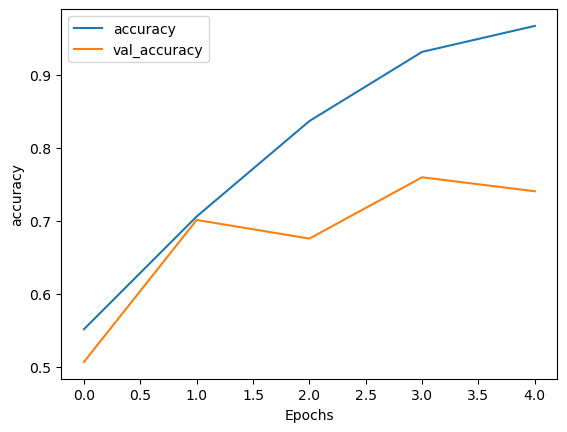

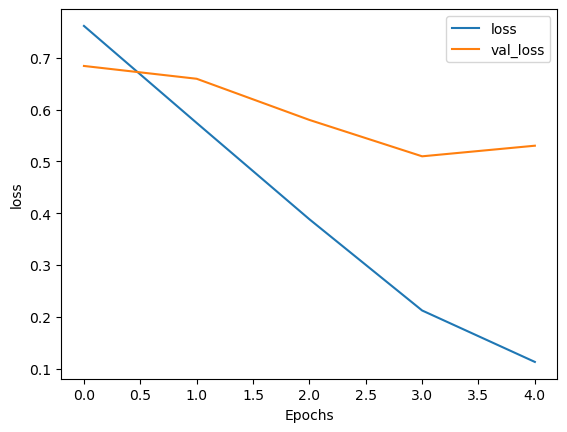

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

25/25 [==============================] - 2s 36ms/step


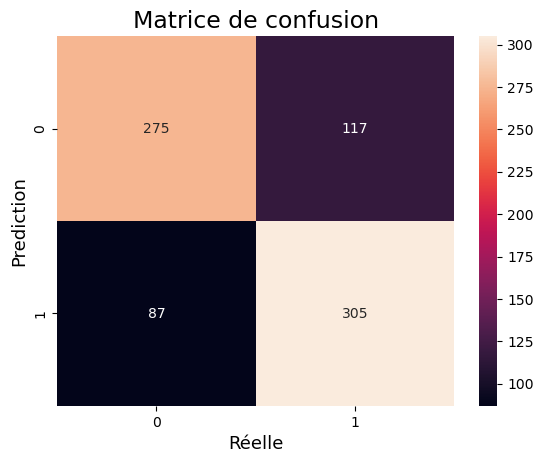

In [ ]:
predicted_test = model.predict( test_padded_sequences)
binary_predictions = (predicted_test > 0.5).astype(int)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix( y_test, binary_predictions)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Réelle',fontsize=13)
plt.title('Matrice de confusion',fontsize=17)
plt.show()

In [ ]:
new_comment = "لا لاجبارية التلقيح اولاد للل"

new_comment = split_into_words( new_comment)

new_comment = remove_stopwords( new_comment)

test_encoding = DarijaBERT_tokenizer(  new_comment, truncation=True, padding='max_length', max_length=maxlen)

new_comment_padded = pad_sequences( test_encoding['input_ids'], maxlen=maxlen, padding='post', truncating='post')

prediction = model.predict( new_comment_padded)
predicted_sentiment = "Positive" if prediction[0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}, Confidence: {prediction[0][0]}")

NameError: name 'split_into_words' is not defined

In [ ]:
from tensorflow.keras.models import load_model

the_model = load_model('best_model_26_11.keras')

In [ ]:
new_comment = "لا لاجبارية التلقيح اولاد للل"

new_comment = split_into_words( new_comment)

new_comment = remove_stopwords( new_comment)

test_encoding = DarijaBERT_tokenizer(  new_comment, truncation=True, padding='max_length', max_length=maxlen)

new_comment_padded = pad_sequences( test_encoding['input_ids'], maxlen=maxlen, padding='post', truncating='post')

prediction = the_model.predict( new_comment_padded)
predicted_sentiment = "Positive" if prediction[0] > 0.5 else "Negative"

print(f"Predicted Sentiment: {predicted_sentiment}, Confidence: {prediction[0][0]}")

1/1 [==============================] - 0s 50ms/step
Predicted Sentiment: Negative, Confidence: 0.4428183436393738
